In [1]:
import pylab as plt
import time as time
from math import log
from sys import stderr
import random as random


def timer(f, *args, **kwargs):
    """
    This can be used for testing the speed of certain operations.
    """
    start = time.perf_counter_ns()
    f(*args, **kwargs)
    return time.perf_counter_ns() - start

### A few helper functions
There are several functions required to perform RSA. The most interesting is `bezout(a,b)` which solves for integer $s$ and $t$ given positive integers $a$ and $b$ so that $$sa + tb = \gcd(a,b)$$ 

In [2]:
def gcd(m,n):
    k = m % n
    return n if k == 0 else gcd(n, k) 

In [3]:
def bezout(a, b):
    """

    bezout: Finds s and t so that s*m + t*n = gcd
     If gcd(m,n) = 1, then a mod n = m^-1 mod n

     The point at each stage of the Eucldean algorithm
     Assume a >= b(not necessary)
     r_0 = a, r_1 = b, r_2 = r_0 mod r_1, ... r_i = r_{i-2} mod r_{i-1}
     So r_0 > r_1 > r_2 ... >= 0
     At each stage s_i*a + t_i*b = a_i
     q_i*a_{i-1} + a_i = a_{i-2}
     q_i(s_{i-1}*a + t_{i-1}*b) + a_i = s_{i-2}*a + t_{i-2}*b
     [s_i, t_i] = [s_{i-2}, t_{i-2}] - q_i*[s_{i-1}, t_{i-1}] (*)
     and q_i = floor(a_{i-2}/a_{i-1})
     As soon as r_{i} = 0 we are done and want to take s_{i-1}, t_{i - 1}
     (*) indicates why I use "pairs" rather than s, t
     Themain point is there is some s, t so that:
           gcd(a,b) = gcd(b, a mod b) = s*a + t*b
     Tracking this gives the algorithm
    """


    a0 = [1, 0]  # [s_{i-2}, t_{i-2}]
    a1 = [0, 1]  # [s_{i-1}, t_{i-1}]

    B = [a, b]
    r = b

    while r > 0:
        aa = a0[0]*B[0] + a0[1]*B[1]  # a_{i-2}
        bb = a1[0]*B[0] + a1[1]*B[1]  # a_{i-1}
        r = aa % bb  # a_i
        if r == 0:
            break
        q = aa // bb  # q_i
        tmp = [x - q*y for x,y in zip(a0, a1)]  # [s_i, t_i]
        a0 = a1  # reset for next round
        a1 = tmp;
    s = a1[0]; t = a1[1]; gcd = bb;
    return (s, t, gcd)

Computing $m^e \bmod \phi(n)$ or $c^d \bmod \phi(n)$ can take a long time if exponentiation without thinking. The following uses about $\log_2(d)$ multiplication and mod operations instead of the $d$ many of these operations if `m ** d % n` were used.

In [4]:
def fast_exp(m,e,n):
    if e == 0: 
        return 1
    if e == 1:
        return m % n
    tmp = fast_exp(m, e >> 1, n)
    if (e >> 1) < ((e + 1) >> 1):
        return (tmp * tmp * m) % n
    return (tmp * tmp) % n

The following plot indictes the time difference between using fast_exp and not for relatively small exponents. The blue is the running time of regular exponentiation in nanoseconds.

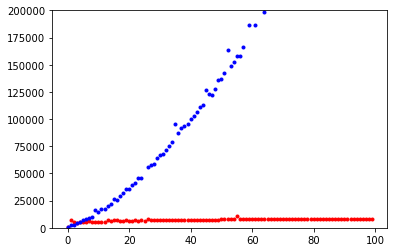

In [5]:
ns = [i*20 for i in range(0,100)]
b = random.randint(2**20,2**21)
N = 2**63
times1 = [timer(fast_exp, b, i, N) for i in ns]
times2 = [timer(lambda : b**i % N) for i in ns]
fig, ax = plt.subplots()
ax.set_ylim(0, 200000)
ax.plot(times1, 'r.')
pt = ax.plot(times2,'b.')

The next two helper functions convert a text message to an integer and vice versa.

In [6]:
def message_to_int(message):
    """
    Simply feed in one ascii code for a character at a time. So
    message_to_int("Hi") -> 0x4869, since, H -> 0x48 and i -> 0x69.
    """
    int_message = 0
    for c in message:
        int_message = (int_message << 8) + ord(c)
    return int_message
    
def int_to_message(n):
    message = ""
    while n > 0:
        B = n % 256
        n = n >> 8
        c = chr(B)
        message = c + message
    return message

Two more helper functions, isPrime does the obvious test, it optimizes a bit by testing only odd possible factors for primes and only up to the square root of n. The function Primes does a complete prime factorization of n. It is really the running time of these and similar functions that make RSA secure. If you try the isPrime on p or q below in the "Real World" parameters section, then don't plan on seeing the process terminate. To test primality on truely large numbers probabilistic primality tests are used. It is also useful to know about how likely you are to find a prime, the Prime Number Theorem basically provides that if an odd number is chosen at random that is around n bits, then the probability that that number is prime is approximately $\frac{2}{n\ln(2)}$. so if we choose a random odd number, $\tilde p$, that is around 516 bits, then $P(\tilde p\in\text{Primes})=\frac{2}{216\cdot\log(2)}\approx 1.34\%$. After  53 random attempts the probability for finding a prime is already over 50\%.

In [7]:
def isPrime(n):
    if n == 2:
        return True
    if n % 2 == 0:
        return False
    i = 1
    while (2*i+1)*(2*i + 1) <= n:
        if n % (2*i + 1) == 0:
            return False
        i += 1
    return True   

def Primes(n):
    i = 2
    a = []
    while i * i <= n:
        while n % i == 0:
            n = n // i
            a.append(i)
        if i == 2:
            i += 1
        else:
            i += 2  # Need only check odds.
    if n > 1:
        a.append(n)
    return a

### Real World RSA parameters

Here would be some "real world" prime pairs. These are 1024 bits, but our codes run too slow on these.

In [8]:
p = 0xE0DFD2C2A288ACEBC705EFAB30E4447541A8C5A47A37185C5A9CB98389CE4DE19199AA3069B404FD98C801568CB9170EB712BF10B4955CE9C9DC8CE6855C6123
q = 0xEBE0FCF21866FD9A9F0D72F7994875A8D92E67AEE4B515136B2A778A8048B149828AEA30BD0BA34B977982A3D42168F594CA99F3981DDABFAB2369F229640115
n = 0xCF33188211FDF6052BDBB1A37235E0ABB5978A45C71FD381A91AD12FC76DA0544C47568AC83D855D47CA8D8A779579AB72E635D0B0AAAC22D28341E998E90F82122A2C06090F43A37E0203C2B72E401FD06890EC8EAD4F07E686E906F01B2468AE7B30CBD670255C1FEDE1A2762CF4392C0759499CC0ABECFF008728D9A11ADF
e = 0x40B028E1E4CCF07537643101FF72444A0BE1D7682F1EDB553E3AB4F6DD8293CA1945DB12D796AE9244D60565C2EB692A89B8881D58D278562ED60066DD8211E67315CF89857167206120405B08B54D10D4EC4ED4253C75FA74098FE3F7FB751FF5121353C554391E114C85B56A9725E9BD5685D6C9C7EED8EE442366353DC39
d = 0xC21A93EE751A8D4FBFD77285D79D6768C58EBF283743D2889A395F266C78F4A28E86F545960C2CE01EB8AD5246905163B28D0B8BAABB959CC03F4EC499186168AE9ED6D88058898907E61C7CCCC584D65D801CFE32DFC983707F87F5AA6AE4B9E77B9CE630E2C0DF05841B5E4984D059A35D7270D500514891F7B77B804BED81

# You can test that d = e^-1 mod phi
phi = (p-1)*(q-1)

check = "e and d are inverses mod phi" if e * d % phi == 1 else "e and d are not inverses mod phi"
print(check, file=stderr)

# You can even run bezout(e, (p - 1)*(q - 1)) to get d (so this is clearly not  slow operation!)
(d, _, _) = bezout(e, phi) 
hex(d % phi)

e and d are inverses mod phi


'0xc21a93ee751a8d4fbfd77285d79d6768c58ebf283743d2889a395f266c78f4a28e86f545960c2ce01eb8ad5246905163b28d0b8baabb959cc03f4ec499186168ae9ed6d88058898907e61c7cccc584d65d801cfe32dfc983707f87f5aa6ae4b9e77b9ce630e2c0df05841b5e4984d059a35d7270d500514891f7b77b804bed81'

### Generate Primes

These function generate primes to use for RSA. You can choose the size of the primes to look for. Do not try a size like 1024 bits as required for real RSA applications! 

In [9]:
import random as random

def gen_prime(bits=32):
    """
    Search for a prime around 32 bits.
    """
    p = random.randint(2**bits, 2**(bits+1))
    while not isPrime(p):
        p = random.randint(2**bits, 2**(bits+1))
    return p

def gen_prime_pair(seed=None, bits=32):
    random.seed(seed)
    p = gen_prime(bits)
    q = p
    while (q == p):
        q = gen_prime(bits)
    return p,q

### The RSA algorithm

Here is the actual RSA. The first function uses the gen_prime_pair together with a seed for the random number generator (the "pass phrase" -- really just noise.) The encoding function simply takes the message, converts it to an integer, $m$, which must be $< n-1$ and then computes $c = m^e \bmod n$. This is the cypher text. The decoding function, then computes $c^d \bmod n$ which is again $m$ and then reconstructs the text from its numeric representation.  

In [10]:
def RSA_gen_key_pair(pass_phrase, bits = 32):
    """
    Decide if you wish to use a 32 bit or a 64 bit primes
    and enter a pass phrase. This generates a (public, private)
    pair, public = (n, e) where n = p*q, private = d so that
    e*d  = 1 (mod phi) where phi = (p-1)*(q-1). 
    
    The message to be encoded must be < n and so if n has k-bits, 
    then the message length is roughly k/8. (8 bits = 1 byte per
    character.) Since n is roughly 2 * bits, bits should be set
    to "message length" * 4 at least.
    """
    p, q = gen_prime_pair(pass_phrase, bits)
    n = p * q
    m = (p - 1)*(q - 1)
    gcd = 0
    while gcd != 1:
        e = random.randint(23, n)
        (d, s, gcd) = bezout(e, m)
        public = (n, e)
        private = d
    return public, private % m
    
def RSA_encode(public, message):
    m = message_to_int(message)
    if m > public[0] - 1:
        print("Message is too long only %s charaters are allowed."%(int((log(public[0])/log(2))/8)),file=stderr)
    return fast_exp(m, public[1], public[0])

def RSA_decode(public, private, cypher):
    return int_to_message(fast_exp(cypher, private, public[0]))

### Generate public, private key pair.
There are things to watch out for. Suppose I wish to code "Hello", this is five 8 bit (1 byte) characters, or 40 bits. For n to have 40 bits we need p and q to have around 20 bits so when running the key_gen, we need to use bits = 20. 

In [11]:
public, private = RSA_gen_key_pair("My Secret Key", 20)

### Encode the plain text message "Hello".

In [12]:
cypher = RSA_encode(public, "Hello")

In [13]:
print("The hex version of the cypher text is {} this is what is \
transmitted \nalong with the public key (n, e) = ({},{}).".format(hex(cypher),hex(public[0]), hex(public[1])))

The hex version of the cypher text is 0x10af90b6d95 this is what is transmitted 
along with the public key (n, e) = (0x1fa9e568c77,0xf40d28d477).


### Decode the original message.

In [14]:
message = RSA_decode(public, private, cypher)
print(message)

Hello


### Breaking RSA
The following simulates a brute force break of a 32 bit RSA encryption. The primes are chosen to be 16 bit, so the search space has size $2^{16}=65536$.

In [15]:
public, private = RSA_gen_key_pair("My Secret Key", 16)
cypher = RSA_encode(public, "CODE")

Break the encryption by factoring n. (Brute force.)

In [16]:
n = public[0]
e = public[1]
p, q = Primes(n)
phi = (p - 1) * (q - 1)
(d, _, _) = bezout(e, phi)
d = d % phi
plain_text = fast_exp(cypher, d, n)
message = int_to_message(plain_text)

By brute force, iterate through all possibilities for the private key $d$ and see which result in the given plain texts.

In [17]:
message

'CODE'